Problema 6.13 página 58 del libro 'Aplicando Teoría de Colas en Dirección de Operaciones':



La peluquería m@ripuri está dirigida y gestionada únicamente por su 
propietaria.. Atiende según el principio de que el primero que entra es el primero 
que sale. La peluquería, dado su carácter cibernético está muy ocupada los 
sábados por la mañana y la propietaria se plantea la posibilidad de contratar a una 
ayudante. Así pues, hace un estudio y se da cuenta de que los clientes llegan con 
una distribución de Poisson de media 5 clientes por hora. Debido a su excelente 
reputación los clientes están dispuestos a esperar lo que haga falta. La propietaria, 
señora Purificación, sigue con sus estudios y estima que el tiempo medio en el que 
atiende un cliente es de 10 minutos según una distribución exponencial. Decide 
primero calcular el número medio de clientes en el salón y el número de medio de 
clientes esperando un corte de pelo . Sólo tiene 4 sillas además del sillón de 
peluquera, ¿cuál es la probabilidad de que llegue un cliente y no encuentre sitio?, 
¿cuál es la probabilidad de que alguien espere más de 45 minutos?

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [81]:
# Configuración inicial
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
np.random.seed(42)  # Reproducibilidad

In [82]:
#Simulación Base
def run_simulation(simulation_hours=8760, num_chairs=5):
    # Generar eventos de llegada y servicio
    inter_arrivals = np.random.exponential(1/5, int(1.5 * 5 * simulation_hours))
    arrival_times = np.cumsum(inter_arrivals)
    arrival_times = arrival_times[arrival_times <= simulation_hours]
    service_times = np.random.exponential(1/6, len(arrival_times))
    
    # Simulación FIFO
    queue = []
    waiting_times = []
    system_occupancy = []
    
    for i in range(len(arrival_times)):
        arrival = arrival_times[i]
        service_time = service_times[i]
        
        # Procesar salidas
        while queue and queue[0][0] <= arrival:
            departure, client_arrival = queue.pop(0)
            waiting_times.append(departure - client_arrival)
        
        # Gestión de sillas
        if len(queue) < num_chairs:
            if not queue:
                departure_time = arrival + service_time
            else:
                departure_time = queue[-1][0] + service_time
            queue.append((departure_time, arrival))
        
        system_occupancy.append(len(queue))
    
    return {
        'waiting_times': waiting_times,
        'system_occupancy': system_occupancy,
        'arrival_times': arrival_times
    }

In [83]:
#%% Análisis de Convergencia
def convergence_analysis():
    time_points = np.linspace(100, 8760, 50)
    avg_clients = []
    
    for t in time_points:
        results = run_simulation(t)
        avg_clients.append(np.mean(results['system_occupancy']))
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, avg_clients, 'b-', lw=2)
    plt.axhline(y=5, color='r', linestyle='--', label='Valor teórico')
    plt.xlabel('Horas de Simulación')
    plt.ylabel('Clientes Promedio')
    plt.title('Convergencia del Sistema')
    plt.legend()
    plt.savefig('images/convergencia.png', dpi=300)
    plt.show()

In [84]:
#%% Distribución de Esperas
def plot_waiting_distribution():
    results = run_simulation(8760)
    waiting_hours = np.array(results['waiting_times'])
    
    plt.figure(figsize=(10, 6))
    sns.histplot(waiting_hours*60, kde=True, bins=50, 
                color='teal', stat='density')
    plt.xlabel('Minutos de Espera')
    plt.title('Distribución de Tiempos de Espera')
    plt.savefig('images/distribucion_espera.png', dpi=300)
    plt.show()

In [85]:
#%% Intervalos de Confianza
def confidence_intervals(n_simulations=30):
    simulations = [run_simulation(2000) for _ in range(n_simulations)]
    avg_clients = [np.mean(s['system_occupancy']) for s in simulations]
    
    mean = np.mean(avg_clients)
    ci = stats.t.interval(0.95, len(avg_clients)-1, 
                         loc=mean, scale=stats.sem(avg_clients))
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(0, mean, yerr= mean-ci[0], fmt='o', 
                capsize=10, markersize=8)
    plt.xlim(-0.5, 0.5)
    plt.xticks([])
    plt.ylabel('Clientes Promedio')
    plt.title('Intervalo de Confianza 95%')
    plt.savefig('images/intervalo_confianza.png', dpi=300)
    plt.show()

In [86]:
#%% Prueba de Hipótesis
def hypothesis_test():
    import pandas as pd
    
    data = []
    for chairs in [5, 6]:
        for _ in range(20):
            sim_result = run_simulation(2000, chairs)
            data.extend([(x, f'{chairs} Sillas') for x in sim_result['system_occupancy']])
    
    df = pd.DataFrame(data, columns=['Clientes', 'Configuración'])
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Configuración', y='Clientes', data=df)
    plt.title('Impacto del Número de Sillas')
    plt.savefig('images/hipotesis.png', dpi=300, bbox_inches='tight')
    plt.show()

⚙️ Ejecutando simulación completa...
══════════════════════════════════════════════════
📊 RESULTADOS COMPLETOS DE LA SIMULACIÓN
══════════════════════════════════════════════════

🔹 Métricas clave:
- Clientes promedio en sistema: 2.88
- Tiempo espera promedio: 26.2 minutos
- Prob. de no encontrar asiento: 9.93%
- Prob. de espera >45 min: 17.51%

📈 Estadísticas de espera:
- Máxima espera: 168.7 minutos
- Mínima espera: 0.0 minutos
- Percentil 95%: 66.7 min

📦 Ocupación del sistema:
- Máximo clientes simultáneos: 5
- % tiempo con todas las sillas ocupadas: 22.07%


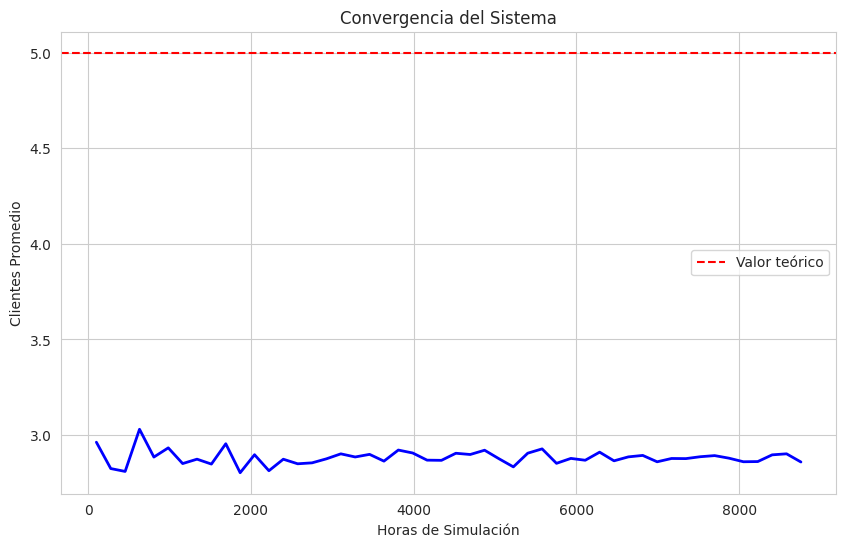

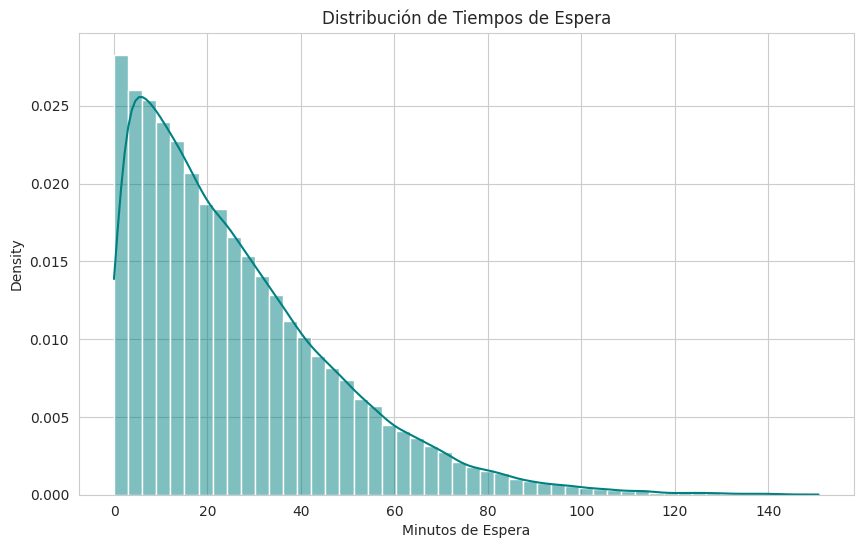

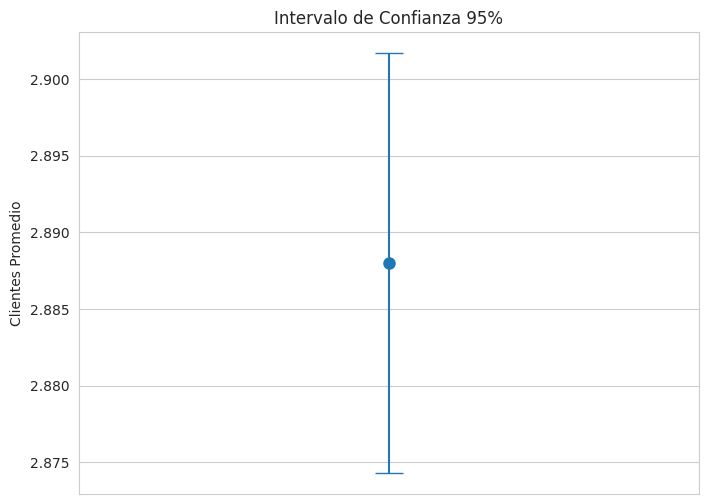

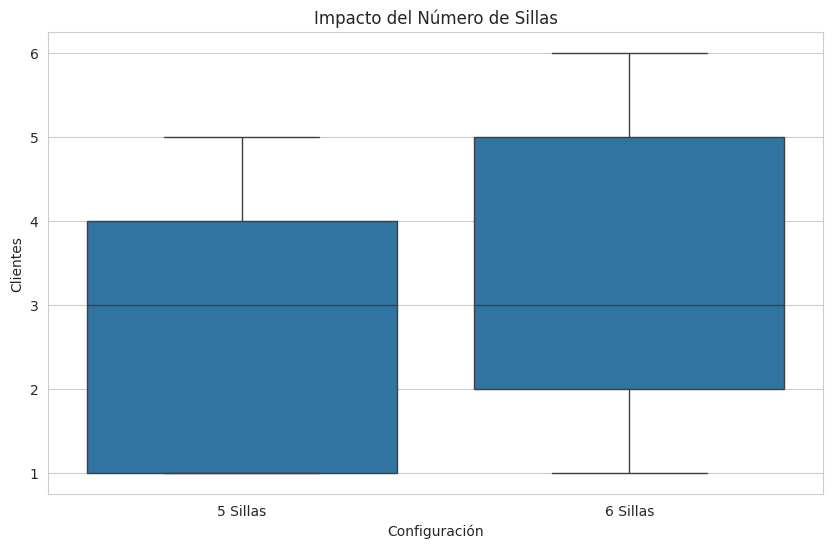


✅ Todos los análisis fueron guardados como imágenes (.png)


In [87]:
def print_simulation_results(results):
    # Métricas básicas
    avg_clients = np.mean(results['system_occupancy'])
    avg_wait = np.mean(results['waiting_times'])
    prob_no_seat = 1 - (len(results['waiting_times']) / len(results['arrival_times']))
    prob_long_wait = np.mean(np.array(results['waiting_times']) > 0.75)
    
    print("═"*50)
    print("📊 RESULTADOS COMPLETOS DE LA SIMULACIÓN")
    print("═"*50)
    print(f"\n🔹 Métricas clave:")
    print(f"- Clientes promedio en sistema: {avg_clients:.2f}")
    print(f"- Tiempo espera promedio: {avg_wait*60:.1f} minutos")
    print(f"- Prob. de no encontrar asiento: {prob_no_seat:.2%}")
    print(f"- Prob. de espera >45 min: {prob_long_wait:.2%}")
    
    print(f"\n📈 Estadísticas de espera:")
    print(f"- Máxima espera: {np.max(results['waiting_times'])*60:.1f} minutos")
    print(f"- Mínima espera: {np.min(results['waiting_times'])*60:.1f} minutos")
    print(f"- Percentil 95%: {np.percentile(results['waiting_times'], 95)*60:.1f} min")
    
    print(f"\n📦 Ocupación del sistema:")
    print(f"- Máximo clientes simultáneos: {np.max(results['system_occupancy'])}")
    print(f"- % tiempo con todas las sillas ocupadas: {np.mean(np.array(results['system_occupancy']) >= 5):.2%}")

def run_full_analysis():
    print("⚙️ Ejecutando simulación completa...")
    results = run_simulation(8760)  # 1 año de simulación
    
    print_simulation_results(results)
    
    # Gráficos adicionales
    convergence_analysis()
    plot_waiting_distribution()
    confidence_intervals()
    hypothesis_test()
    
    print("\n✅ Todos los análisis fueron guardados como imágenes (.png)")

# Ejecutar todo
run_full_analysis()